# Activity_Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm 
from scipy.stats import norm
import pylab as py 
import statistics
import math
import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, LSTM, Softmax, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model
from matplotlib import pyplot
%matplotlib inline

In [2]:
path = "/home/ronaldson_bellande/Desktop/Healthcare Data Analytics/Research_Project/Force data/"
sitting_data = pd.read_csv(path + 'sitting.csv')
standing_data = pd.read_csv(path + 'standing.csv')
walking_data = pd.read_csv(path + 'walking.csv')

In [3]:
sitting_data.head()

,Force (N)
0,4.013054
1,3.977287
2,3.903191
3,3.882751
4,3.862312


In [4]:
mean = [statistics.mean(sitting_data['Force (N)']), statistics.mean(standing_data['Force (N)']),statistics.mean(walking_data['Force (N)'])]

In [5]:
variance = [statistics.variance(sitting_data['Force (N)']),statistics.variance(standing_data['Force (N)']),statistics.variance(walking_data['Force (N)'])]

In [6]:
print(mean)
print(variance)

[3.0191525700887043, 5.121795862833659, 7.124916610717773]
[0.22500154437870737, 2.4457547060344678, 6.8334862244644565]


In [7]:
sigma = []
for i in range(0,len(variance)):
    sigma1 = math.sqrt(variance[i])
    sigma.append(sigma1)

Text(0, 0.5, 'Probability Density')

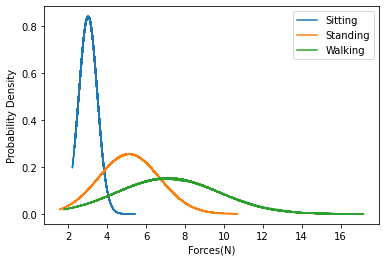

In [8]:
plt.plot(sitting_data['Force (N)'], norm.pdf(sitting_data['Force (N)'],mean[0],sigma[0]))
plt.plot(standing_data['Force (N)'], norm.pdf(standing_data['Force (N)'],mean[1],sigma[1]))
plt.plot(walking_data['Force (N)'], norm.pdf(walking_data['Force (N)'],mean[2],sigma[2]))
plt.legend(('Sitting','Standing','Walking'))
plt.xlabel('Forces(N)')  
plt.ylabel('Probability Density')

Text(0, 0.5, 'Probability Density')

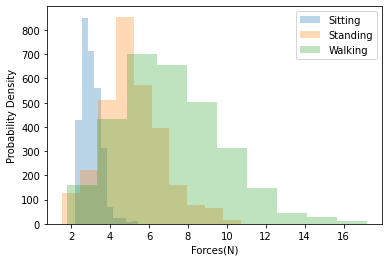

In [9]:
plt.hist(sitting_data['Force (N)'],alpha=0.3 )
plt.hist(standing_data['Force (N)'], alpha=0.3)
plt.hist(walking_data['Force (N)'], alpha=0.3)
plt.legend(('Sitting','Standing','Walking'))
plt.xlabel('Forces(N)')  
plt.ylabel('Probability Density')

In [10]:
print(sitting_data.shape)
print(standing_data.shape)
print(walking_data.shape)

(3000, 1)
(3000, 1)
(3000, 1)


In [11]:
batch_size = 1
number_classes = 10
epochs = 100

In [12]:
# Fix random seed for reproducibility
np.random.seed(7)
# Load dataset
sitting_set = sitting_data.values
standing_set = standing_data.values
walking_set = walking_data.values

In [13]:
# normalize the datasets
scaler = MinMaxScaler(feature_range=(0,1))
sitting_set = scaler.fit_transform(sitting_set)
standing_set = scaler.fit_transform(standing_set)
walking_set = scaler.fit_transform(walking_set)

In [14]:
#Split into training set and test set
train_size = int(len(sitting_set) * 0.80)
test_size = len(sitting_set) - train_size
train_sitting, test_sitting = sitting_set[0:train_size,:], sitting_set[train_size:len(sitting_set),:]
train_standing, test_standing = standing_set[0:train_size,:], standing_set[train_size:len(standing_set),:]
train_walking, test_walking = walking_set[0:train_size,:], walking_set[train_size:len(walking_set),:]

In [15]:
# Comvert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        temp = dataset[i:(i+look_back), 0]
        dataX.append(temp)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
#Reshape for training into X=t and Y=t+1 as [sample, features]
train_sitting_X, train_sitting_Y = create_dataset(train_sitting)
train_standing_X, train_standing_Y = create_dataset(train_standing)
train_walking_X, train_walking_Y = create_dataset(train_walking)

In [17]:
# Reshape tesing [sample, features]
test_sitting_X, test_sitting_Y = create_dataset(test_sitting)
test_standing_X, test_standing_Y = create_dataset(test_standing)
test_walking_X, test_walking_Y = create_dataset(test_walking)

In [18]:
# Now reshape to be [samples, time steps, features] for the X_axis for training data
train_sitting_X = np.reshape(train_sitting_X, (train_sitting_X.shape[0], 1, train_sitting_X.shape[1]))
train_standing_X = np.reshape(train_standing_X, (train_standing_X.shape[0], 1, train_standing_X.shape[1]))
train_walking_X = np.reshape(train_walking_X, (train_walking_X.shape[0], 1, train_walking_X.shape[1]))

In [19]:
# Now reshape to be [samples, time steps, features] for the X_axis for test data
test_sitting_X = np.reshape(test_sitting_X, (test_sitting_X.shape[0], 1, test_sitting_X.shape[1]))
test_standing_X = np.reshape(test_standing_X, (test_standing_X.shape[0], 1, test_standing_X.shape[1]))
test_walking_X = np.reshape(test_walking_X, (test_walking_X.shape[0], 1, test_walking_X.shape[1]))

In [20]:
timed = keras.callbacks.EarlyStopping(monitor="val_acc", patience = 0, verbose=1)

In [21]:
# Create and the fit the LSTM network, with 1 visible layer with 1 input and a hitten
# layer with 4 LSTM neurons
model = Sequential()
model.add(LSTM(4, input_shape=(1,1)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam",metrics = ["Accuracy"])
sitting_model = model.fit(train_sitting_X, train_sitting_Y, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(train_sitting_X, train_sitting_Y), shuffle=True,callbacks=[timed])

Epoch 1/100
2398/2398 - 14s - loss: 0.0196 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 2/100
2398/2398 - 6s - loss: 5.1975e-04 - accuracy: 0.0000e+00 - val_loss: 2.3876e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
2398/2398 - 7s - loss: 2.5076e-04 - accuracy: 0.0000e+00 - val_loss: 2.3468e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
2398/2398 - 6s - loss: 2.5538e-04 - accuracy: 0.0000e+00 - val_loss: 2.7231e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
2398/2398 - 7s - loss: 2.5494e-04 - accuracy: 0.0000e+00 - val_loss: 2.4482e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
2398/2398 - 7s - loss: 2.5828e-04 - accuracy: 0.0000e+00 - val_loss: 2.5849e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
2398/2398 - 7s - loss: 2.4784e-04 - accuracy: 0.0000e+00 - val_loss: 2.5583e-04 - val_accuracy: 0.0000e+00
Epoch 8/100
2398/2398 - 8s - loss: 2.4883e-04 - accuracy: 0.0000e+00 - val_loss: 2.5900e-04 - val_accuracy: 0.0000e+00
Epoch 9/100
2398/2398 - 6s - loss: 2.4966e-04 - accurac

2398/2398 - 6s - loss: 2.3873e-04 - accuracy: 0.0000e+00 - val_loss: 2.2429e-04 - val_accuracy: 0.0000e+00
Epoch 32/100
2398/2398 - 7s - loss: 2.4148e-04 - accuracy: 0.0000e+00 - val_loss: 2.2723e-04 - val_accuracy: 0.0000e+00
Epoch 33/100
2398/2398 - 8s - loss: 2.3892e-04 - accuracy: 0.0000e+00 - val_loss: 2.2243e-04 - val_accuracy: 0.0000e+00
Epoch 34/100
2398/2398 - 12s - loss: 2.3790e-04 - accuracy: 0.0000e+00 - val_loss: 2.1925e-04 - val_accuracy: 0.0000e+00
Epoch 35/100
2398/2398 - 16s - loss: 2.4392e-04 - accuracy: 0.0000e+00 - val_loss: 2.6329e-04 - val_accuracy: 0.0000e+00
Epoch 36/100
2398/2398 - 16s - loss: 2.3892e-04 - accuracy: 0.0000e+00 - val_loss: 2.3542e-04 - val_accuracy: 0.0000e+00
Epoch 37/100
2398/2398 - 15s - loss: 2.3837e-04 - accuracy: 0.0000e+00 - val_loss: 2.6492e-04 - val_accuracy: 0.0000e+00
Epoch 38/100
2398/2398 - 6s - loss: 2.3924e-04 - accuracy: 0.0000e+00 - val_loss: 2.6977e-04 - val_accuracy: 0.0000e+00
Epoch 39/100
2398/2398 - 6s - loss: 2.3615e-04 - 

2398/2398 - 6s - loss: 2.3463e-04 - accuracy: 0.0000e+00 - val_loss: 2.3874e-04 - val_accuracy: 0.0000e+00
Epoch 63/100
2398/2398 - 6s - loss: 2.3469e-04 - accuracy: 0.0000e+00 - val_loss: 2.3562e-04 - val_accuracy: 0.0000e+00
Epoch 64/100
2398/2398 - 6s - loss: 2.3270e-04 - accuracy: 0.0000e+00 - val_loss: 2.2103e-04 - val_accuracy: 0.0000e+00
Epoch 65/100
2398/2398 - 6s - loss: 2.3800e-04 - accuracy: 0.0000e+00 - val_loss: 2.1491e-04 - val_accuracy: 0.0000e+00
Epoch 66/100
2398/2398 - 6s - loss: 2.3570e-04 - accuracy: 0.0000e+00 - val_loss: 2.5441e-04 - val_accuracy: 0.0000e+00
Epoch 67/100
2398/2398 - 6s - loss: 2.3343e-04 - accuracy: 0.0000e+00 - val_loss: 2.9010e-04 - val_accuracy: 0.0000e+00
Epoch 68/100
2398/2398 - 6s - loss: 2.3387e-04 - accuracy: 0.0000e+00 - val_loss: 2.4989e-04 - val_accuracy: 0.0000e+00
Epoch 69/100
2398/2398 - 6s - loss: 2.3205e-04 - accuracy: 0.0000e+00 - val_loss: 2.2115e-04 - val_accuracy: 0.0000e+00
Epoch 70/100
2398/2398 - 7s - loss: 2.3368e-04 - accu

2398/2398 - 9s - loss: 2.3145e-04 - accuracy: 0.0000e+00 - val_loss: 2.3215e-04 - val_accuracy: 0.0000e+00
Epoch 93/100
2398/2398 - 8s - loss: 2.3015e-04 - accuracy: 0.0000e+00 - val_loss: 2.1417e-04 - val_accuracy: 0.0000e+00
Epoch 94/100
2398/2398 - 8s - loss: 2.3061e-04 - accuracy: 0.0000e+00 - val_loss: 2.1870e-04 - val_accuracy: 0.0000e+00
Epoch 95/100
2398/2398 - 9s - loss: 2.2859e-04 - accuracy: 0.0000e+00 - val_loss: 2.2111e-04 - val_accuracy: 0.0000e+00
Epoch 96/100
2398/2398 - 9s - loss: 2.3160e-04 - accuracy: 0.0000e+00 - val_loss: 2.1124e-04 - val_accuracy: 0.0000e+00
Epoch 97/100
2398/2398 - 9s - loss: 2.2995e-04 - accuracy: 0.0000e+00 - val_loss: 2.7719e-04 - val_accuracy: 0.0000e+00
Epoch 98/100
2398/2398 - 9s - loss: 2.3075e-04 - accuracy: 0.0000e+00 - val_loss: 2.1163e-04 - val_accuracy: 0.0000e+00
Epoch 99/100
2398/2398 - 9s - loss: 2.2968e-04 - accuracy: 0.0000e+00 - val_loss: 2.1793e-04 - val_accuracy: 0.0000e+00
Epoch 100/100
2398/2398 - 9s - loss: 2.2822e-04 - acc

In [22]:
model.save('lstm_model_sitting.h5')

In [23]:
# Make prediction for sitting
training_prediction_sitting = model.predict(train_sitting_X)
test_prediction_sitting = model.predict(test_sitting_X)
# Invert Prediction
train_prediction_invert_sitting = scaler.inverse_transform(training_prediction_sitting)
train_sitting_Y = scaler.inverse_transform([train_sitting_Y])
test_prediction_invert_sitting = scaler.inverse_transform(test_prediction_sitting)
test_sitting_Y = scaler.inverse_transform([test_sitting_Y])

In [24]:
# Calculating the root error
training_score = math.sqrt(mean_squared_error(train_sitting_Y[0],train_prediction_invert_sitting[:,0]))
print('Training Score:', (training_score))
testing_score = math.sqrt(mean_squared_error(test_sitting_Y[0],test_prediction_invert_sitting[:,0]))
print('Testing Score:', (testing_score))

Training Score: 0.23663134241980893
Testing Score: 0.2288257869008604


In [25]:
# Trained Prediction
trainingPredictPlot_sitting = np.empty_like(sitting_set)
trainingPredictPlot_sitting[:, :] = np.nan
trainingPredictPlot_sitting[1:len(train_prediction_invert_sitting)+1, :] = train_prediction_invert_sitting

In [26]:
# Test Prediction
testPredictPlot_sitting = np.empty_like(sitting_set)
testPredictPlot_sitting[:, :] = np.nan
testPredictPlot_sitting[len(train_prediction_invert_sitting)+(1*2)+1:len(sitting_set)-1, :] = test_prediction_invert_sitting

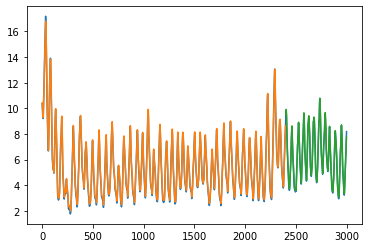

In [27]:
# Predictions
plt.plot(scaler.inverse_transform(sitting_set))
plt.plot(trainingPredictPlot_sitting)
plt.plot(testPredictPlot_sitting)
plt.savefig('sitting_set.png', dpi=500)
plt.show()

In [29]:
# scores = model.evaluate(test_sitting_X,test_sitting_Y)
# print('Loss: %.2f' %scores[0])
# print('Accuracy: %0.2f' %scores[1])

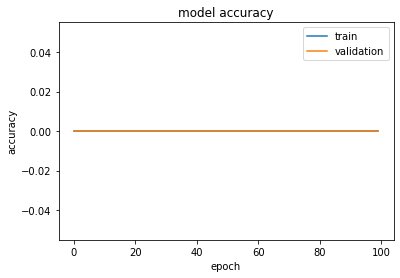

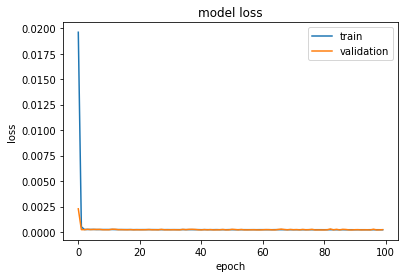

In [30]:
pyplot.plot(sitting_model.history['accuracy'])
pyplot.plot(sitting_model.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
plt.savefig('sitting_set_model_accuracy.png', dpi=500)
pyplot.show()
pyplot.plot(sitting_model.history['loss'])
pyplot.plot(sitting_model.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
plt.savefig('sitting_set_model_lost.png', dpi=500)
pyplot.show()

In [31]:
# Create and the fit the LSTM network, with 1 visible layer with 1 input and a hitten
# layer with 4 LSTM neurons
model = Sequential()
model.add(LSTM(4, input_shape=(1,1)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam",metrics = ["Accuracy"])

In [32]:
standing_model = model.fit(train_standing_X, train_standing_Y, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(train_standing_X, train_standing_Y), shuffle=True,callbacks=[timed])
model.save('lstm_model_standing.h5')

Epoch 1/100
2398/2398 - 7s - loss: 0.0293 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 2/100
2398/2398 - 6s - loss: 7.0097e-04 - accuracy: 0.0000e+00 - val_loss: 2.7208e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
2398/2398 - 7s - loss: 2.8599e-04 - accuracy: 0.0000e+00 - val_loss: 3.0641e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
2398/2398 - 6s - loss: 2.7869e-04 - accuracy: 0.0000e+00 - val_loss: 2.4893e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
2398/2398 - 7s - loss: 2.7226e-04 - accuracy: 0.0000e+00 - val_loss: 2.8887e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
2398/2398 - 6s - loss: 2.7506e-04 - accuracy: 0.0000e+00 - val_loss: 2.4610e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
2398/2398 - 6s - loss: 2.7675e-04 - accuracy: 0.0000e+00 - val_loss: 2.5918e-04 - val_accuracy: 0.0000e+00
Epoch 8/100
2398/2398 - 6s - loss: 2.7213e-04 - accuracy: 0.0000e+00 - val_loss: 2.8496e-04 - val_accuracy: 0.0000e+00
Epoch 9/100
2398/2398 - 6s - loss: 2.7402e-04 - accuracy

2398/2398 - 6s - loss: 2.6935e-04 - accuracy: 0.0000e+00 - val_loss: 2.5075e-04 - val_accuracy: 0.0000e+00
Epoch 32/100
2398/2398 - 6s - loss: 2.7090e-04 - accuracy: 0.0000e+00 - val_loss: 2.9321e-04 - val_accuracy: 0.0000e+00
Epoch 33/100
2398/2398 - 6s - loss: 2.7128e-04 - accuracy: 0.0000e+00 - val_loss: 2.4406e-04 - val_accuracy: 0.0000e+00
Epoch 34/100
2398/2398 - 6s - loss: 2.6707e-04 - accuracy: 0.0000e+00 - val_loss: 2.5066e-04 - val_accuracy: 0.0000e+00
Epoch 35/100
2398/2398 - 6s - loss: 2.6937e-04 - accuracy: 0.0000e+00 - val_loss: 3.0551e-04 - val_accuracy: 0.0000e+00
Epoch 36/100
2398/2398 - 6s - loss: 2.6828e-04 - accuracy: 0.0000e+00 - val_loss: 2.4632e-04 - val_accuracy: 0.0000e+00
Epoch 37/100
2398/2398 - 6s - loss: 2.7310e-04 - accuracy: 0.0000e+00 - val_loss: 2.5014e-04 - val_accuracy: 0.0000e+00
Epoch 38/100
2398/2398 - 6s - loss: 2.7067e-04 - accuracy: 0.0000e+00 - val_loss: 2.4537e-04 - val_accuracy: 0.0000e+00
Epoch 39/100
2398/2398 - 6s - loss: 2.6881e-04 - accu

2398/2398 - 6s - loss: 2.6516e-04 - accuracy: 0.0000e+00 - val_loss: 3.1900e-04 - val_accuracy: 0.0000e+00
Epoch 63/100
2398/2398 - 6s - loss: 2.6876e-04 - accuracy: 0.0000e+00 - val_loss: 2.8754e-04 - val_accuracy: 0.0000e+00
Epoch 64/100
2398/2398 - 6s - loss: 2.7080e-04 - accuracy: 0.0000e+00 - val_loss: 2.9047e-04 - val_accuracy: 0.0000e+00
Epoch 65/100
2398/2398 - 6s - loss: 2.7980e-04 - accuracy: 0.0000e+00 - val_loss: 2.7131e-04 - val_accuracy: 0.0000e+00
Epoch 66/100
2398/2398 - 6s - loss: 2.7023e-04 - accuracy: 0.0000e+00 - val_loss: 2.8321e-04 - val_accuracy: 0.0000e+00
Epoch 67/100
2398/2398 - 7s - loss: 2.6059e-04 - accuracy: 0.0000e+00 - val_loss: 4.3262e-04 - val_accuracy: 0.0000e+00
Epoch 68/100
2398/2398 - 7s - loss: 2.6950e-04 - accuracy: 0.0000e+00 - val_loss: 2.5510e-04 - val_accuracy: 0.0000e+00
Epoch 69/100
2398/2398 - 6s - loss: 2.7010e-04 - accuracy: 0.0000e+00 - val_loss: 2.5905e-04 - val_accuracy: 0.0000e+00
Epoch 70/100
2398/2398 - 7s - loss: 2.6398e-04 - accu

2398/2398 - 8s - loss: 2.6847e-04 - accuracy: 0.0000e+00 - val_loss: 2.4914e-04 - val_accuracy: 0.0000e+00
Epoch 94/100
2398/2398 - 8s - loss: 2.6677e-04 - accuracy: 0.0000e+00 - val_loss: 2.6704e-04 - val_accuracy: 0.0000e+00
Epoch 95/100
2398/2398 - 8s - loss: 2.6535e-04 - accuracy: 0.0000e+00 - val_loss: 3.1686e-04 - val_accuracy: 0.0000e+00
Epoch 96/100
2398/2398 - 8s - loss: 2.6676e-04 - accuracy: 0.0000e+00 - val_loss: 2.6812e-04 - val_accuracy: 0.0000e+00
Epoch 97/100
2398/2398 - 8s - loss: 2.7114e-04 - accuracy: 0.0000e+00 - val_loss: 2.4067e-04 - val_accuracy: 0.0000e+00
Epoch 98/100
2398/2398 - 8s - loss: 2.6844e-04 - accuracy: 0.0000e+00 - val_loss: 2.4658e-04 - val_accuracy: 0.0000e+00
Epoch 99/100
2398/2398 - 8s - loss: 2.6632e-04 - accuracy: 0.0000e+00 - val_loss: 2.4745e-04 - val_accuracy: 0.0000e+00
Epoch 100/100
2398/2398 - 8s - loss: 2.6775e-04 - accuracy: 0.0000e+00 - val_loss: 2.4155e-04 - val_accuracy: 0.0000e+00


In [33]:
# Make prediction for standing
training_prediction_standing = model.predict(train_standing_X)
test_prediction_standing = model.predict(test_standing_X)
# Invert Prediction
train_prediction_invert_standing = scaler.inverse_transform(training_prediction_standing)
train_standing_Y = scaler.inverse_transform([train_standing_Y])
test_prediction_invert_standing = scaler.inverse_transform(test_prediction_standing)
test_standing_Y = scaler.inverse_transform([test_standing_Y])
# Calculating the root error
training_score = math.sqrt(mean_squared_error(train_standing_Y[0],train_prediction_invert_standing[:,0]))
print('Training Score:', (training_score))
testing_score = math.sqrt(mean_squared_error(test_standing_Y[0],test_prediction_invert_standing[:,0]))
print('Testing Score:', (testing_score))

Training Score: 0.23972674809205913
Testing Score: 0.19348015216482062


In [34]:
# Trained Prediction
trainingPredictPlot_standing = np.empty_like(standing_set)
trainingPredictPlot_standing[:, :] = np.nan
trainingPredictPlot_standing[1:len(train_prediction_invert_standing)+1, :] = train_prediction_invert_standing
# Test Prediction
testPredictPlot_standing = np.empty_like(standing_set)
testPredictPlot_standing[:, :] = np.nan
testPredictPlot_standing[len(train_prediction_invert_standing)+(1*2)+1:len(standing_set)-1, :] = test_prediction_invert_standing

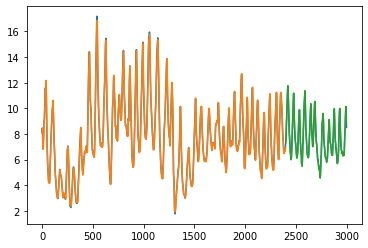

In [35]:
# Predictions
plt.plot(scaler.inverse_transform(standing_set))
plt.plot(trainingPredictPlot_standing)
plt.plot(testPredictPlot_standing)
plt.savefig('standing_set.png',dpi=500)
plt.show()

In [36]:
# scores = model.evaluate(test_standing_X,test_standing_Y)
# print('Loss: %.2f' %scores[0])
# print('Accuracy: %0.2f' %scores[1])

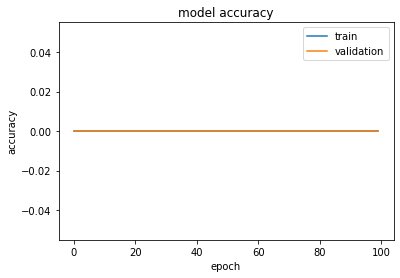

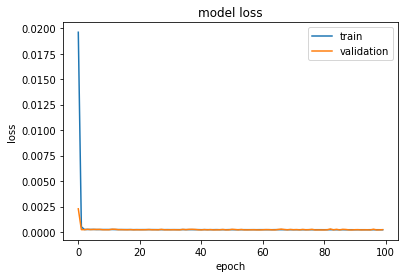

In [37]:
pyplot.plot(sitting_model.history['accuracy'])
pyplot.plot(sitting_model.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
plt.savefig('standing_set_model_accuracy.png', dpi=500)
pyplot.show()
pyplot.plot(sitting_model.history['loss'])
pyplot.plot(sitting_model.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
plt.savefig('standing_set_model_lost.png', dpi=500)
pyplot.show()

In [38]:
# Create and the fit the LSTM network, with 1 visible layer with 1 input and a hitten
# layer with 4 LSTM neurons
model = Sequential()
model.add(LSTM(4, input_shape=(1,1)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam",metrics = ["Accuracy"])
model.fit(train_walking_X, train_walking_Y, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(train_walking_X, train_walking_Y), shuffle=True,callbacks=[timed])
model.save('lstm_model_walking.h5')

Epoch 1/100
2398/2398 - 6s - loss: 0.0134 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2/100
2398/2398 - 6s - loss: 6.6348e-04 - accuracy: 0.0000e+00 - val_loss: 5.9904e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
2398/2398 - 6s - loss: 6.2764e-04 - accuracy: 0.0000e+00 - val_loss: 6.0301e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
2398/2398 - 6s - loss: 6.2807e-04 - accuracy: 0.0000e+00 - val_loss: 6.0572e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
2398/2398 - 7s - loss: 6.3102e-04 - accuracy: 0.0000e+00 - val_loss: 6.2288e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
2398/2398 - 6s - loss: 6.2765e-04 - accuracy: 0.0000e+00 - val_loss: 7.9614e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
2398/2398 - 6s - loss: 6.3186e-04 - accuracy: 0.0000e+00 - val_loss: 6.6854e-04 - val_accuracy: 0.0000e+00
Epoch 8/100
2398/2398 - 7s - loss: 6.2436e-04 - accuracy: 0.0000e+00 - val_loss: 6.6711e-04 - val_accuracy: 0.0000e+00
Epoch 9/100
2398/2398 - 11s - loss: 6.2149e-04 - accurac

2398/2398 - 9s - loss: 6.2199e-04 - accuracy: 0.0000e+00 - val_loss: 5.9455e-04 - val_accuracy: 0.0000e+00
Epoch 32/100
2398/2398 - 12s - loss: 6.2568e-04 - accuracy: 0.0000e+00 - val_loss: 6.3698e-04 - val_accuracy: 0.0000e+00
Epoch 33/100
2398/2398 - 9s - loss: 6.2733e-04 - accuracy: 0.0000e+00 - val_loss: 6.3360e-04 - val_accuracy: 0.0000e+00
Epoch 34/100
2398/2398 - 12s - loss: 6.3156e-04 - accuracy: 0.0000e+00 - val_loss: 6.0207e-04 - val_accuracy: 0.0000e+00
Epoch 35/100
2398/2398 - 15s - loss: 6.2686e-04 - accuracy: 0.0000e+00 - val_loss: 6.3083e-04 - val_accuracy: 0.0000e+00
Epoch 36/100
2398/2398 - 18s - loss: 6.2793e-04 - accuracy: 0.0000e+00 - val_loss: 6.1889e-04 - val_accuracy: 0.0000e+00
Epoch 37/100
2398/2398 - 10s - loss: 6.2673e-04 - accuracy: 0.0000e+00 - val_loss: 6.0231e-04 - val_accuracy: 0.0000e+00
Epoch 38/100
2398/2398 - 10s - loss: 6.2501e-04 - accuracy: 0.0000e+00 - val_loss: 6.3125e-04 - val_accuracy: 0.0000e+00
Epoch 39/100
2398/2398 - 11s - loss: 6.2888e-04

2398/2398 - 6s - loss: 6.2715e-04 - accuracy: 0.0000e+00 - val_loss: 5.9926e-04 - val_accuracy: 0.0000e+00
Epoch 63/100
2398/2398 - 6s - loss: 6.2588e-04 - accuracy: 0.0000e+00 - val_loss: 6.0836e-04 - val_accuracy: 0.0000e+00
Epoch 64/100
2398/2398 - 6s - loss: 6.2248e-04 - accuracy: 0.0000e+00 - val_loss: 5.9229e-04 - val_accuracy: 0.0000e+00
Epoch 65/100
2398/2398 - 6s - loss: 6.1591e-04 - accuracy: 0.0000e+00 - val_loss: 5.9421e-04 - val_accuracy: 0.0000e+00
Epoch 66/100
2398/2398 - 6s - loss: 6.1502e-04 - accuracy: 0.0000e+00 - val_loss: 5.8689e-04 - val_accuracy: 0.0000e+00
Epoch 67/100
2398/2398 - 6s - loss: 6.2602e-04 - accuracy: 0.0000e+00 - val_loss: 7.3219e-04 - val_accuracy: 0.0000e+00
Epoch 68/100
2398/2398 - 6s - loss: 6.2738e-04 - accuracy: 0.0000e+00 - val_loss: 6.8761e-04 - val_accuracy: 0.0000e+00
Epoch 69/100
2398/2398 - 6s - loss: 6.1919e-04 - accuracy: 0.0000e+00 - val_loss: 6.1169e-04 - val_accuracy: 0.0000e+00
Epoch 70/100
2398/2398 - 6s - loss: 6.1835e-04 - accu

2398/2398 - 6s - loss: 6.2395e-04 - accuracy: 0.0000e+00 - val_loss: 5.9109e-04 - val_accuracy: 0.0000e+00
Epoch 93/100
2398/2398 - 7s - loss: 6.2485e-04 - accuracy: 0.0000e+00 - val_loss: 6.0936e-04 - val_accuracy: 0.0000e+00
Epoch 94/100
2398/2398 - 6s - loss: 6.1454e-04 - accuracy: 0.0000e+00 - val_loss: 6.9670e-04 - val_accuracy: 0.0000e+00
Epoch 95/100
2398/2398 - 7s - loss: 6.2542e-04 - accuracy: 0.0000e+00 - val_loss: 5.9761e-04 - val_accuracy: 0.0000e+00
Epoch 96/100
2398/2398 - 6s - loss: 6.1854e-04 - accuracy: 0.0000e+00 - val_loss: 5.9295e-04 - val_accuracy: 0.0000e+00
Epoch 97/100
2398/2398 - 6s - loss: 6.1922e-04 - accuracy: 0.0000e+00 - val_loss: 6.1102e-04 - val_accuracy: 0.0000e+00
Epoch 98/100
2398/2398 - 6s - loss: 6.2443e-04 - accuracy: 0.0000e+00 - val_loss: 5.8822e-04 - val_accuracy: 0.0000e+00
Epoch 99/100
2398/2398 - 6s - loss: 6.1992e-04 - accuracy: 0.0000e+00 - val_loss: 6.4711e-04 - val_accuracy: 0.0000e+00
Epoch 100/100
2398/2398 - 7s - loss: 6.2116e-04 - acc

In [39]:
# Make prediction for walking
training_prediction_walking = model.predict(train_walking_X)
test_prediction_walking = model.predict(test_walking_X)
# Invert Prediction
train_prediction_invert_walking = scaler.inverse_transform(training_prediction_walking)
train_walking_Y = scaler.inverse_transform([train_walking_Y])
test_prediction_invert_walking = scaler.inverse_transform(test_prediction_walking)
test_walking_Y = scaler.inverse_transform([test_walking_Y])

In [40]:
# Calculating the root error
training_score = math.sqrt(mean_squared_error(train_walking_Y[0],train_prediction_invert_walking[:,0]))
print('Training Score:', (training_score))
testing_score = math.sqrt(mean_squared_error(test_walking_Y[0],test_prediction_invert_walking[:,0]))
print('Testing Score:', (testing_score))
# Trained Prediction
trainingPredictPlot_walking = np.empty_like(walking_set)
trainingPredictPlot_walking[:, :] = np.nan
trainingPredictPlot_walking[1:len(train_prediction_invert_walking)+1, :] = train_prediction_invert_walking
# Test Prediction
testPredictPlot_walking = np.empty_like(walking_set)
testPredictPlot_walking[:, :] = np.nan
testPredictPlot_walking[len(train_prediction_invert_walking)+(1*2)+1:len(walking_set)-1, :] = test_prediction_invert_walking

Training Score: 0.37307089333766486
Testing Score: 0.427685572040959


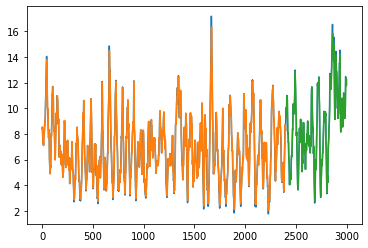

In [41]:
# Predictions
plt.plot(scaler.inverse_transform(walking_set))
plt.plot(trainingPredictPlot_walking)
plt.plot(testPredictPlot_walking)
plt.savefig('walking_set.png',dpi=500)
plt.show()

In [42]:
# scores = model.evaluate(test_walking_X,test_walking_Y)
# print('Loss: %.2f' %scores[0])
# print('Accuracy: %0.2f' %scores[1])

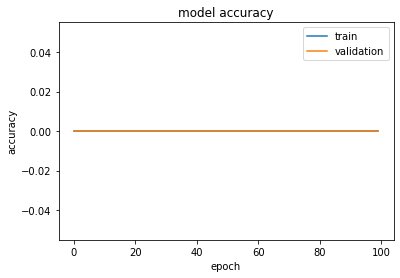

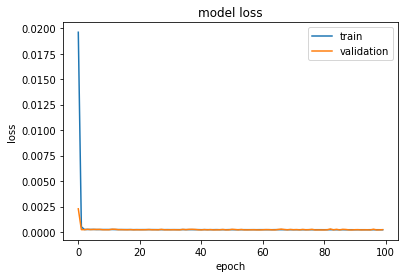

In [43]:
pyplot.plot(sitting_model.history['accuracy'])
pyplot.plot(sitting_model.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
plt.savefig('walking_set_model_accuracy.png', dpi=500)
pyplot.show()
pyplot.plot(sitting_model.history['loss'])
pyplot.plot(sitting_model.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
plt.savefig('walking_set_model_lost.png', dpi=500)
pyplot.show()